In [ ]:
from util.ml_data import MLData
from util.modify_inp import qchem_out_aimd_multi
import numpy as np

In [4]:
from util.ml_data import MLData
from util.modify_inp import qchem_out_aimd_multi
import numpy as np


prefix = "./examples/phbdi/full_"
path = "./examples/phbdi/"
multi = qchem_out_aimd_multi()
multi.read_files([
    "./examples/phbdi/aimd_phbdi_nvt_1.out",
])



# 转换成 kcal/mol, Angstrom, kcal/mol/Angstrom

multi.export_numpy(prefix=prefix,
                   energy_unit="kcal",
                   distance_unit="ang",
                   force_unit=("kcal", "ang"))




(array([[[-2.13349988e+00, -3.09287158e+00,  9.48830430e-03],
         [-2.88553746e-01, -1.96650333e+00,  8.83486360e-03],
         [-1.35407194e+00, -9.72793620e-01,  8.26890670e-03],
         ...,
         [ 3.41631863e+00, -5.63045006e+00,  1.82262954e-02],
         [ 5.62719638e+00, -1.89148930e+00,  4.46584080e-03],
         [ 5.79696642e+00, -4.51729227e+00,  1.48621327e-02]],
 
        [[-2.13440974e+00, -3.09382628e+00,  7.91227430e-03],
         [-2.86478355e-01, -1.96424211e+00,  5.50838650e-03],
         [-1.35788591e+00, -9.72277096e-01,  2.43245010e-03],
         ...,
         [ 3.41032655e+00, -5.64502468e+00,  2.07469473e-02],
         [ 5.62643778e+00, -1.88158764e+00, -2.61004210e-03],
         [ 5.79838759e+00, -4.51843775e+00,  1.57015585e-02]],
 
        [[-2.13522701e+00, -3.09450434e+00,  6.45952780e-03],
         [-2.84732484e-01, -1.96219530e+00,  2.05188790e-03],
         [-1.36175900e+00, -9.72403531e-01, -3.22481130e-03],
         ...,
         [ 3.40584179e

In [5]:
# 1. 读取 (可扩展字段)
dataset = MLData(prefix=prefix, files=["coord","energy","grad","type"])

# 2. 保存划分
train = 1000
test = int(train/5)
val = int(train/5)
dataset.save_split(train, val, test, prefix=f"{path}{train}_")

# 3. 加载 split 并切片
split = np.load(f"{path}{train}_split.npz", allow_pickle=True)
train_data = dataset.get_split_data(split, part="idx_train")
val_data   = dataset.get_split_data(split, part="idx_val")
energies = np.load(f"{prefix}energy.npy", allow_pickle=True)
ex

Loaded dataset with 5000 frames, 27 atoms
Saved split to ./examples/phbdi/1000_split.npz (idx_train=1000, idx_val=200, idx_test=200)


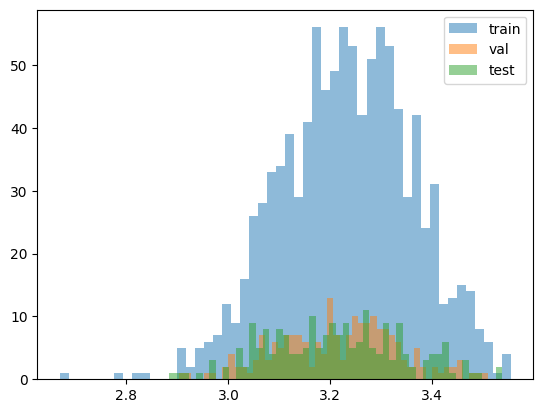

In [2]:
import matplotlib.pyplot as plt
prefix = "./phbdi_tddft_datas/full_"
path = "./phbdi_tddft_datas/"
train = 1000
energies = np.load(f"{prefix}ex_energy.npy", allow_pickle=True)
split = np.load(f"{path}{train}_split.npz", allow_pickle=True)
plt.hist(energies[split["idx_train"]], bins=50, alpha=0.5, label="train")
plt.hist(energies[split["idx_val"]], bins=50, alpha=0.5, label="val")
plt.hist(energies[split["idx_test"]], bins=50, alpha=0.5, label="test")
plt.legend(); plt.show()


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- 加载数据 ---
coords = np.load(f"{path}full_coord.npy")     # (N, Natoms, 3)
energies = np.load(f"{path}full_energy.npy")  # (N,)
grads = np.load(f"{path}full_grad.npy")       # (N, Natoms, 3)

forces = grads   # 如果 full_grad 已经是力，请把这行改成 forces = grads

N = len(coords)

def energy_diff_from_forces(R0, R1, F0, F1):
    """用梯形规则积分力估算能量差"""
    dR = R1 - R0  # (Natoms, 3)
    work0 = np.sum(F0 * dR)
    work1 = np.sum(F1 * dR)
    return -0.5 * (work0 + work1)

# --- 随机取一些片段做对比 ---
ncheck = 200
idxs = random.sample(range(N-1), ncheck)

dE_ref = []
dE_int = []

for i in idxs:
    R0, R1 = coords[i], coords[i+1]
    E0, E1 = energies[i], energies[i+1]
    F0, F1 = forces[i], forces[i+1]

    dE_ref.append(E1 - E0)
    dE_int.append(energy_diff_from_forces(R0, R1, F0, F1))

dE_ref = np.array(dE_ref)
dE_int = np.array(dE_int)

# --- 打印统计 ---
corr = np.corrcoef(dE_ref, dE_int)[0,1]
mae = np.mean(np.abs(dE_ref - dE_int))
print("ΔE_ref vs ΔE_int correlation:", corr)
print("Mean abs error:", mae)

# --- 可视化 ---
plt.figure(figsize=(6,6))
plt.scatter(dE_ref, dE_int, alpha=0.6)
plt.plot([dE_ref.min(), dE_ref.max()], [dE_ref.min(), dE_ref.max()], "r--")
plt.xlabel("Reference ΔE (kcal/mol)")
plt.ylabel("Integrated Force ΔE (kcal/mol)")
plt.title("Energy difference vs Force integral")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './phbdi_tddft_datas/full_energy.npy'

In [1]:
from scipy.stats import linregress
import numpy as np

# 用你刚才脚本算出来的数组
slope, intercept, r, *_ = linregress(dE_ref, dE_int)
print("slope =", slope)  # 这就是比例 k，理想应为 1

NameError: name 'dE_ref' is not defined